In [79]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
sys.path.append("/workspace/localizing-edm/")

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchinfo import summary
import json
import torch
import dnnlib
import pickle
import pandas as pd
import numpy as np

from scorer import VEScorer, plot_score_grid
from flows import ScoreFlow, build_model, log_density
from torch.nn.functional import interpolate

root = '/workspace/localizing-edm/workdir/runs'
model_file = f"{root}/finetune_cifar/00024-mvtec_hazelnut_128-uncond-ncsnpp-ve-gpus2-batch128-fp32/network-snapshot-010095.pkl"
device = torch.device('cuda')

with dnnlib.util.open_url(model_file) as f:
    model = pickle.load(f)
    net = model["ema"]
model.keys()

dict_keys(['ema', 'loss_fn', 'augment_pipe', 'dataset_kwargs'])

In [81]:
model_root = "/".join(model_file.split("/")[:-1])
model_root

'/workspace/localizing-edm/workdir/runs/finetune_cifar/00024-mvtec_hazelnut_128-uncond-ncsnpp-ve-gpus2-batch128-fp32'

In [82]:
with open(f"{model_root}/stats.jsonl", "r") as f:
    stats = pd.read_json(path_or_buf=f, lines=True)

# Extraact the nested object from the first line
nested_object = stats['Loss/loss']

# Convert the nested object to a DataFrame
df = pd.DataFrame.from_records(nested_object)

# Display the DataFrame
print(df)

           num      mean       std
0      6291456  0.029795  0.153952
1    497025024  0.030935  0.156265
2    497025024  0.033160  0.163131
3    497025024  0.033437  0.164635
4    497025024  0.031798  0.160568
..         ...       ...       ...
800  497025024  0.027369  0.137489
801  497025024  0.025982  0.132117
802  497025024  0.027463  0.137714
803  497025024  0.027549  0.137662
804  497025024  0.027568  0.139200

[805 rows x 3 columns]


In [83]:
df['mean'].plot()

<AxesSubplot: >

In [84]:
net.init_kwargs

{'model_type': 'SongUNet',
 'embedding_type': 'fourier',
 'encoder_type': 'residual',
 'decoder_type': 'standard',
 'channel_mult_noise': 2,
 'resample_filter': [1, 3, 3, 1],
 'model_channels': 128,
 'channel_mult': (1, 2, 2, 2),
 'augment_dim': 15,
 'dropout': 0.1,
 'use_fp16': False,
 'num_blocks': 4,
 'img_resolution': 32,
 'img_channels': 3,
 'label_dim': 0}

In [333]:
augment_pipe = model["augment_pipe"]
augment_pipe.init_kwargs

{'p': 0.08,
 'xflip': 100000000.0,
 'yflip': 1,
 'scale': 1,
 'rotate_frac': 1,
 'aniso': 1,
 'translate_frac': 1,
 'brightness': 1,
 'contrast': 1,
 'lumaflip': 1,
 'hue': 1,
 'saturation': 1}

In [86]:
model["dataset_kwargs"]

{'class_name': 'training.dataset.MVTecDataset',
 'path': '/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut',
 'use_labels': False,
 'xflip': False,
 'cache': True,
 'resolution': 128,
 'max_size': 391}

In [87]:
res =  model["dataset_kwargs"]["resolution"]

In [290]:
from training.dataset import MVTecDataset

mvtec_ds = MVTecDataset(path="/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut",
                        train=False, resolution=128)
inlier_samples, _ = mvtec_ds.load_test(only_normal=True)
ood_samples, mask = mvtec_ds.load_test(skip_normal=True)
inlier_samples = torch.stack(inlier_samples).to(device) / 127.5 - 1
ood_samples = torch.stack(ood_samples) / 127.5 - 1
mask = torch.stack(mask)
inlier_samples.shape, ood_samples.shape, ood_samples.dtype 

(torch.Size([40, 3, 128, 128]), torch.Size([70, 3, 128, 128]), torch.float32)

In [282]:
flow_path = "/workspace/localizing-edm/workdir/runs/cifar-base/0024/"
config = pd.read_json(f"{flow_path}/config.json")
config

config  augment_pipe  \
run_dir          workdir/runs/cifar-base/0024/           NaN   
fp16                                      True           NaN   
num_epochs                                 200           NaN   
hres_blocks                                  2           NaN   
lres_blocks                                  4           NaN   
num_sigmas                                  20           NaN   
batch_size                                  64           NaN   
sigma_min                                  0.1           NaN   
augment                                   0.08           NaN   
resolution                                None           NaN   
lr                                      0.0003           NaN   
workers                                      4           NaN   
device                                    cuda           NaN   
p                                          NaN  8.000000e-02   
xflip                                      NaN  1.000000e+08   
yflip                                      NaN  1.000000e+00   
scale                                      NaN  1.000000e+00   
rotate_frac                                NaN  1.000000e+00   
aniso                                      NaN  1.000000e+00   
translate_frac                             NaN  1.000000e+00   
brightness                                 NaN  1.000000e+00   
contrast                                   NaN  1.000000e+00   
lumaflip                                   NaN  1.000000e+00   
hue                                        NaN  1.000000e+00   
saturation                                 NaN  1.000000e+00   
class_name                                 NaN           NaN   
path                                       NaN           NaN   
use_labels                                 NaN           NaN   
cache                                      NaN           NaN   
max_size                                   NaN           NaN   
pin_memory                                 NaN           NaN   
num_workers                                NaN           NaN   
prefetch_factor                            NaN           NaN   

                                                dataset_kwargs  \
run_dir                                                    NaN   
fp16                                                       NaN   
num_epochs                                                 NaN   
hres_blocks                                                NaN   
lres_blocks                                                NaN   
num_sigmas                                                 NaN   
batch_size                                                 NaN   
sigma_min                                                  NaN   
augment                                                    NaN   
resolution                                                 128   
lr                                                         NaN   
workers                                                    NaN   
device                                                     NaN   
p                                                          NaN   
xflip                                                    False   
yflip                                                      NaN   
scale                                                      NaN   
rotate_frac                                                NaN   
aniso                                                      NaN   
translate_frac                                             NaN   
brightness                                                 NaN   
contrast                                                   NaN   
lumaflip                                                   NaN   
hue                                                        NaN   
saturation                                                 NaN   
class_name                       training.dataset.MVTecDataset   
path             /DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut   
use_labels     

In [283]:
num_sigmas = config.config.loc['num_sigmas']
hres_blocks = config.config.loc['hres_blocks']
lres_blocks = config.config.loc['lres_blocks']
use_fp16 = config.config.loc['fp16']
min_sigma = config.config['sigma_min']

In [325]:
conv_inn = build_model((num_sigmas, res, res), num_hres_blocks=hres_blocks, num_lres_blocks=lres_blocks)
flownet = ScoreFlow(conv_inn, net, num_sigmas=num_sigmas, use_fp16=use_fp16, sigma_min=min_sigma,
                    post_downsample=True, vectorize=True).to(device)
state_dict = torch.load(f"{flow_path}/checkpoint.pth")
flownet.load_state_dict(state_dict["model_state_dict"], strict=False)
print("Loaded")

Loaded


<AxesSubplot: >

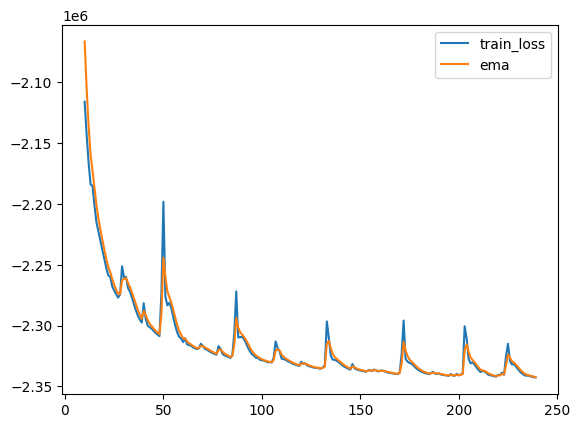

In [301]:
df = pd.read_csv(f"{flow_path}/losses.csv")
df[10:].plot()

In [291]:
summary(flownet.flow, input_data=torch.ones(1,num_sigmas, res, res))

Layer (type:depth-idx)                   Output Shape              Param #
GraphINN                                 [1, 80, 64, 64]           --
├─ModuleList: 1-1                        --                        --
│    └─GLOWCouplingBlock: 2-1            [1, 20, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 20, 128, 128]         69,396
│    │    └─Sequential: 3-2              [1, 20, 128, 128]         69,396
│    └─PermuteRandom: 2-2                [1, 20, 128, 128]         (40)
│    └─GLOWCouplingBlock: 2-3            [1, 20, 128, 128]         --
│    │    └─Sequential: 3-3              [1, 20, 128, 128]         69,396
│    │    └─Sequential: 3-4              [1, 20, 128, 128]         69,396
│    └─PermuteRandom: 2-4                [1, 20, 128, 128]         (40)
│    └─IRevNetDownsampling: 2-5          [1, 80, 64, 64]           (320)
│    └─GLOWCouplingBlock: 2-6            [1, 80, 64, 64]           --
│    │    └─Sequential: 3-5              [1, 80, 64, 64]      

In [292]:
ood_batch = ood_samples[:16].cuda()
inlier_batch = inlier_samples[:16].cuda()

In [384]:
def build_img_grid(imgs, rows):
    b,c,h,w = imgs.shape
    cols = b // rows
    # Channels last
    img = imgs.permute(0,2,3,1).cpu()
    # Make grid of images
    # (x,y), h,w,c
    img = img.reshape(rows,cols,h,w,c)
    # Swap half batch across cols
    # And half across rows
    # x,h y,w, c
    img = img.permute(0,2,1,3,4)
    # for each img_row,
    #    each pixel row will have y images concatted
    #  every subsewuent will
    img = img.reshape(h*rows, w*cols, c)
    
    return img

In [395]:
mvtec_ds = MVTecDataset(path="/DATA/Users/amahmood/GDrive/MVTec_AD/transistor",
                        train=False, resolution=128)
samples, masks = mvtec_ds.load_test(skip_normal=True)
samples =  torch.stack(samples) / 255
masks =  torch.stack(masks)

In [396]:
samples.shape, masks.min()

(torch.Size([40, 3, 128, 128]), tensor(0, dtype=torch.uint8))

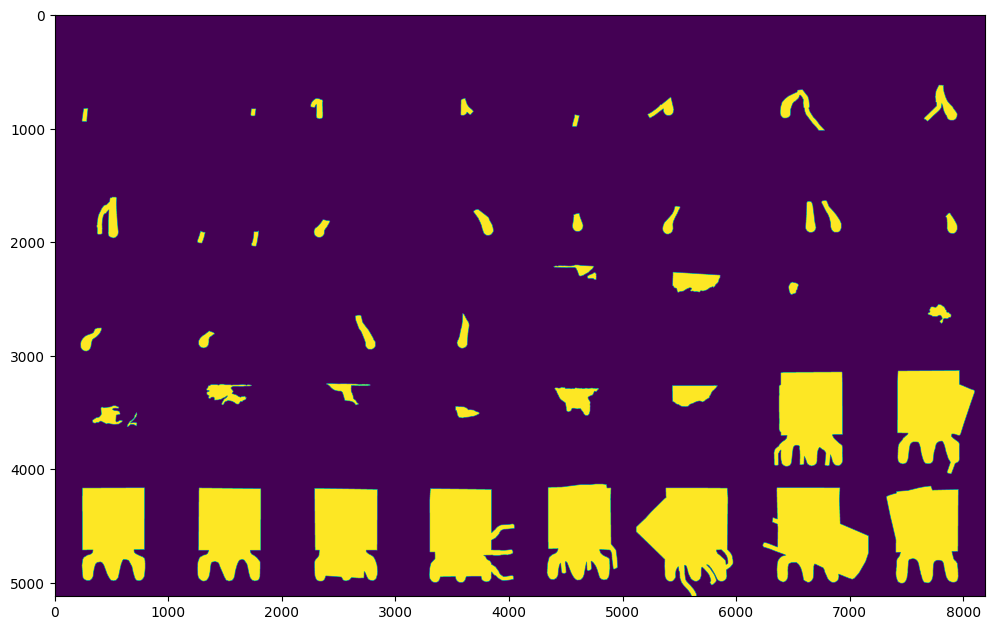

In [397]:
plt.subplots(1,1,figsize=(3*rows,5*cols))
plt.imshow(build_img_grid(masks,rows=5))

In [392]:
plt.subplots(1,1,figsize=(3*rows,5*cols))
plt.imshow(build_img_grid(samples,rows=5))

In [380]:
augment_pipe.p = 0.2
xaug, y = augment_pipe(samples)
rows, cols = 4, b //4
img = build_img_grid(xaug,rows, cols)
img  = 0.5*(img+1)

In [381]:
plt.subplots(1,1,figsize=(3*rows,5*cols))
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [323]:
ood_batch_large = interpolate(ood_batch, scale_factor=2, mode="bilinear", align_corners=False)
ood_batch_large.shape

torch.Size([16, 3, 256, 256])

In [293]:
%%time
vec_scores = flownet.fastscore(ood_batch[:4]).cpu()
vec_scores.shape

CPU times: user 143 ms, sys: 827 ms, total: 970 ms
Wall time: 969 ms


torch.Size([4, 20, 128, 128])

In [294]:
ood_samples.shape

torch.Size([70, 3, 128, 128])

In [295]:
%%time

scores = flownet.scorenet(ood_batch).cpu()
scores.shape

CPU times: user 1.22 s, sys: 2.72 s, total: 3.94 s
Wall time: 3.93 s


torch.Size([16, 20, 128, 128])

In [326]:
%%time
scores_dl = flownet.scorenet(ood_batch_large).cpu()
scores_dl.shape

CPU times: user 7.08 s, sys: 24.5 s, total: 31.6 s
Wall time: 31.8 s


torch.Size([16, 20, 128, 128])

In [296]:
torch.isclose(scores[:4], vec_scores[:4],rtol=1e-5, atol=9e-3).all()

tensor(True)

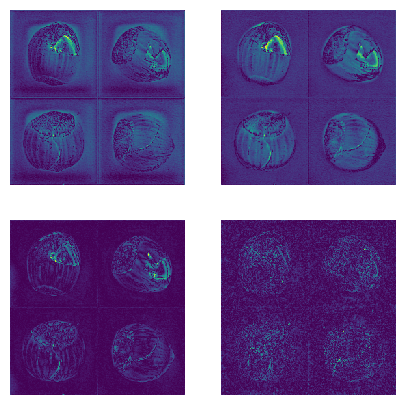

In [329]:
plot_score_grid(scores, num_samples=4, plot_sigma_idxs = [1, 7, 11, 19])
plot_score_grid(scores_dl, num_samples=4, plot_sigma_idxs = [1, 7, 11, 19])

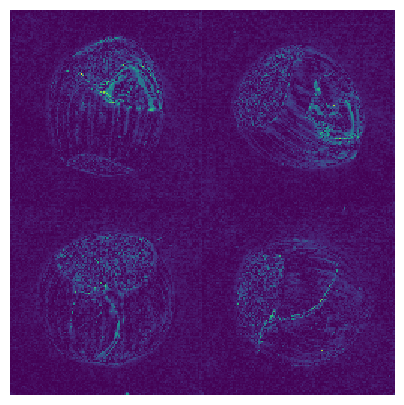

In [330]:
plot_score_grid(scores.sum(dim=1, keepdims=True), num_samples=4, plot_sigma_idxs = [0])
plot_score_grid(scores_dl.sum(dim=1, keepdims=True), num_samples=4, plot_sigma_idxs = [0])

In [299]:
scores.shape

torch.Size([16, 20, 128, 128])

In [300]:
import torch.nn as nn
class SpatialNorm2D(nn.Module):
    def __init__(self, in_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size,
                              groups=in_channels, stride=2, padding=1, bias=False)
        self.conv.weight.data.fill_(1)  # all ones weights
        self.conv.weight.requires_grad = False  # freeze weights
    
    @torch.no_grad()
    def forward(self, x):
        return self.conv(x.square()).pow_(0.5)

norm_pool = torch.jit.script(SpatialNorm2D(num_sigmas, kernel_size=3))

In [234]:
with torch.inference_mode():
    # convolve each sigma with the identity kernel
    sum_kernel = torch.nn.Conv2d(num_sigmas, num_sigmas, groups=num_sigmas,
                                 kernel_size=3, bias=False, stride=2, padding=1)
    sum_kernel.requires_grad = False
    sum_kernel.weight.data.copy_(torch.ones_like(sum_kernel.weight.data))

In [235]:
sum_kernel.weight.data.shape

torch.Size([20, 1, 3, 3])

In [183]:
# scores.requires_grad_()

In [268]:
%%time
with torch.no_grad():
    sum_scores = sum_kernel(scores[:16] ** 2) ** 0.5

CPU times: user 151 ms, sys: 42 ms, total: 193 ms
Wall time: 8.46 ms


In [269]:
%%time
with torch.no_grad():
    norm_scores = norm_pool(scores[:16])

CPU times: user 72.2 ms, sys: 1.04 ms, total: 73.2 ms
Wall time: 5.02 ms


In [270]:
sum_scores.shape, norm_scores.shape

(torch.Size([16, 20, 64, 64]), torch.Size([16, 20, 64, 64]))

In [271]:
torch.isclose(sum_scores, norm_scores).all()

tensor(True)

In [272]:
plot_score_grid(scores.detach(), num_samples=4, plot_sigma_idxs = [1, 7, 11, 19])

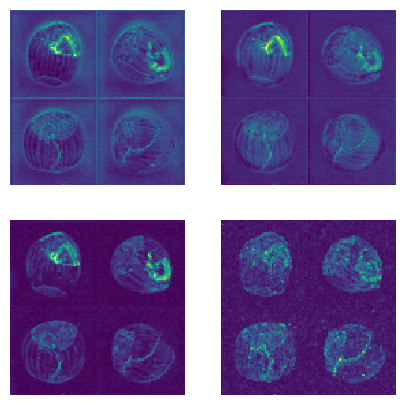

In [273]:
plot_score_grid(norm_scores, num_samples=4, plot_sigma_idxs = [1, 7, 11, 19])

In [302]:
%%time
ood_logpx = []
for x_ood_batch in ood_samples.chunk(10):
    ood_logpx.append(log_density(flownet, x_ood_batch.cuda()).cpu())
ood_logpx = torch.cat(ood_logpx)

CPU times: user 7.34 s, sys: 10.8 s, total: 18.1 s
Wall time: 18.1 s


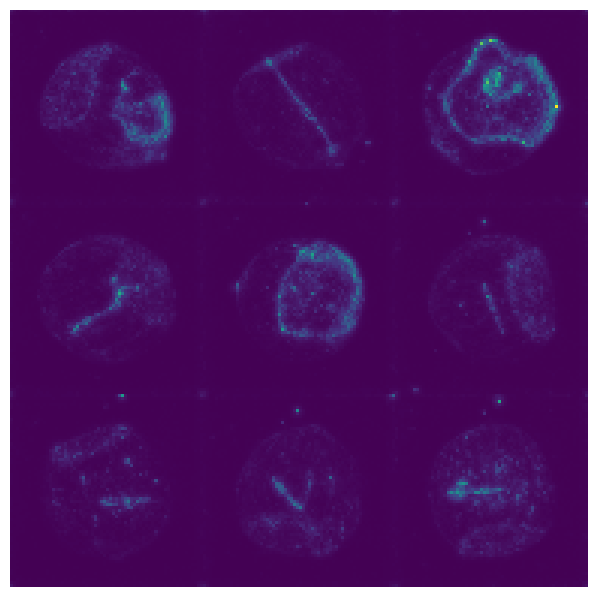

In [303]:
plot_score_grid(ood_logpx[1::4], plot_sigma_idxs=[0])

In [304]:
%%time
inlier_logpx = []
for x_batch in inlier_samples.chunk(10):
    inlier_logpx.append(log_density(flownet, x_batch.cuda()).cpu())
inlier_logpx = torch.cat(inlier_logpx)

CPU times: user 5.7 s, sys: 5.42 s, total: 11.1 s
Wall time: 11.1 s


In [305]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import matplotlib.colors as colors
import cv2 as cv

def plot_batch_with_heatmaps(images_batch, anomaly_maps, clip_val=None, grid_size=(5, 5), blur_radius=5,
                             alpha=0.5, symmetric_norm=True, linthresh_q=0.9):
    # Ensure anomaly_maps have an additional dimension for color channel
#     anomaly_maps = anomaly_maps.unsqueeze(-1)
    
    # Not considering log probabilities higher than threshold
    if clip_val is not None:
        anomaly_maps = anomaly_maps.clip(max=clip_val)
    anomaly_maps = - anomaly_maps.squeeze(1)
    
    # Putting batch as "channel" dimension
    # so kernel is run over all batches (independently)
    anomaly_maps = anomaly_maps.transpose(1,2,0)
    anomaly_maps = cv.blur(anomaly_maps, ksize=(blur_radius,blur_radius))
    anomaly_maps = anomaly_maps.transpose(2,0,1)
    
    amin = anomaly_maps.min(axis=(1,2), keepdims=True)
    amax = anomaly_maps.max(axis=(1,2), keepdims=True) 
    anomaly_maps = (anomaly_maps - amin / (amax-amin))
    
    if symmetric_norm:
        norm=colors.SymLogNorm(linthresh=np.quantile(anomaly_maps,linthresh_q),
                               vmin=np.quantile(anomaly_maps,0.01),
                               vmax=np.quantile(anomaly_maps,0.99))
    else:
        norm=colors.LogNorm(vmin=np.quantile(anomaly_maps,0.01),
                            vmax=np.quantile(anomaly_maps,0.99))
    shape = anomaly_maps.shape
    anomaly_maps  = norm(anomaly_maps.ravel()).reshape(*shape)
    
    # Expand anomaly_maps to 3 color channels and apply colormap
    anomaly_maps_rgb = plt.get_cmap('jet')(anomaly_maps)[:,:,:,:3]
#     anomaly_maps = cv.blur(anomaly_maps, (blur_radius, blur_radius))
#     print(anomaly_maps_rgb.shape)
    anomaly_maps_rgb = torch.from_numpy(anomaly_maps_rgb).float()
    anomaly_maps_rgb = anomaly_maps_rgb.permute(0,3,1,2)
    
    # Merge images with anomaly maps with given alpha
    overlaid_images = alpha * images_batch + (1-alpha) * anomaly_maps_rgb
#     print(overlaid_images.shape)
    # Convert batch of tensors to grid
    grid = vutils.make_grid(overlaid_images, nrow=grid_size[1], padding=2, normalize=True)
    
    # Plot grid
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(np.transpose(grid.numpy(),(1,2,0)))
    
    return anomaly_maps_rgb

In [320]:
inlier_mean_ll = inlier_logpx.quantile(0.5)
inlier_mean_ll

tensor(-2484484.)

In [321]:
# assuming images_batch and anomaly_maps are your data
batch_size = 9
torch.manual_seed(40)
rand_idxs = torch.randperm(ood_batch.shape[0])[:batch_size]
images_batch = ood_batch[rand_idxs].cpu()
heatmap = interpolate(ood_logpx[rand_idxs], scale_factor=2, mode="bilinear", align_corners=False).cpu().contiguous().numpy()

# define grid size and alpha for heatmap opacity
grid_size = (3, 3)
alpha = 0.4

# Call the function with the RGB image batch and the anomaly maps batch
ano = plot_batch_with_heatmaps(images_batch, heatmap, clip_val=inlier_mean_ll.item(),
                               grid_size=grid_size, alpha=alpha, linthresh_q=0.9)

In [322]:
# assuming images_batch and anomaly_maps are your data
batch_size = 9
torch.manual_seed(42)
rand_idxs = torch.randperm(inlier_batch.shape[0])[:batch_size]
inlier_images_batch = inlier_batch[rand_idxs].cpu()
inlier_heatmap = interpolate(inlier_logpx[rand_idxs], scale_factor=2, mode="bilinear", align_corners=False).cpu().numpy()

# define grid size and alpha for heatmap opacity
grid_size = (3, 3)
alpha = 0.4

# Call the function with the RGB image batch and the anomaly maps batch
ano = plot_batch_with_heatmaps(inlier_images_batch, inlier_heatmap, clip_val=inlier_mean_ll.item(),
                               grid_size=grid_size, alpha=alpha, linthresh_q=0.9)

In [319]:
def metrics_evaluation(scores, images, expect_fpr=0.3, max_step=5000):
        from sklearn.metrics import auc
        from sklearn.metrics import roc_auc_score, average_precision_score
        from skimage import measure
        import pandas as pd

        if self.load_model():
            print("Model Loaded.")
        else:
            print("None pretrained models.")
            return
        
        heatmap = interpolate(ood_logpx[rand_idxs], scale_factor=2, mode="bilinear", align_corners=False).cpu().contiguous().numpy()

        print("Calculating AUC, IOU, PRO metrics on testing data...")
        time_start = time.time()
        masks = []
        scores = []
        for i, (img, mask, name) in enumerate(self.test_data_loader):  # batch size is 1.
            # data
            img = img.to(self.device)
            mask = mask.squeeze().numpy()

            # anomaly score
            # anomaly_map = self.score(img).data.cpu().numpy()
            anomaly_map = self.score(img).data.cpu().numpy()

            masks.append(mask)
            scores.append(anomaly_map)
            #print("Batch {},".format(i), "Cost total time {}s".format(time.time() - time_start))

        # as array
        masks = np.array(masks)
        scores = np.array(scores)
        
        # binary masks
        masks[masks <= 0.5] = 0
        masks[masks > 0.5] = 1
        masks = masks.astype(np.bool)
        
        # auc score (image level) for detection
        labels = masks.any(axis=1).any(axis=1)
#         preds = scores.mean(1).mean(1)
        preds = scores.max(1).max(1)    # for detection
        det_auc_score = roc_auc_score(labels, preds)
        det_pr_score = average_precision_score(labels, preds)
        
        # auc score (per pixel level) for segmentation
        seg_auc_score = roc_auc_score(masks.ravel(), scores.ravel())
        seg_pr_score = average_precision_score(masks.ravel(), scores.ravel())
        # metrics over all data
        print(f"Det AUC: {det_auc_score:.4f}, Seg AUC: {seg_auc_score:.4f}")
        print(f"Det PR: {det_pr_score:.4f}, Seg PR: {seg_pr_score:.4f}")
        
        # per region overlap and per image iou
        max_th = scores.max()
        min_th = scores.min()
        delta = (max_th - min_th) / max_step
        
        ious_mean = []
        ious_std = []
        pros_mean = []
        pros_std = []
        threds = []
        fprs = []
        binary_score_maps = np.zeros_like(scores, dtype=np.bool)
        for step in range(max_step):
            thred = max_th - step * delta
            # segmentation
            binary_score_maps[scores <= thred] = 0
            binary_score_maps[scores > thred] = 1

            pro = []    # per region overlap
            iou = []    # per image iou
            # pro: find each connected gt region, compute the overlapped pixels between the gt region and predicted region
            # iou: for each image, compute the ratio, i.e. intersection/union between the gt and predicted binary map 
            for i in range(len(binary_score_maps)):    # for i th image
                # pro (per region level)
                label_map = measure.label(masks[i], connectivity=2)
                props = measure.regionprops(label_map)
                for prop in props:
                    x_min, y_min, x_max, y_max = prop.bbox    # find the bounding box of an anomaly region 
                    cropped_pred_label = binary_score_maps[i][x_min:x_max, y_min:y_max]
                    # cropped_mask = masks[i][x_min:x_max, y_min:y_max]   # bug!
                    cropped_mask = prop.filled_image    # corrected!
                    intersection = np.logical_and(cropped_pred_label, cropped_mask).astype(np.float32).sum()
                    pro.append(intersection / prop.area)
                # iou (per image level)
                intersection = np.logical_and(binary_score_maps[i], masks[i]).astype(np.float32).sum()
                union = np.logical_or(binary_score_maps[i], masks[i]).astype(np.float32).sum()
                if masks[i].any() > 0:    # when the gt have no anomaly pixels, skip it
                    iou.append(intersection / union)
            # against steps and average metrics on the testing data
            ious_mean.append(np.array(iou).mean())
#             print("per image mean iou:", np.array(iou).mean())
            ious_std.append(np.array(iou).std())
            pros_mean.append(np.array(pro).mean())
            pros_std.append(np.array(pro).std())
            # fpr for pro-auc
            masks_neg = ~masks
            fpr = np.logical_and(masks_neg, binary_score_maps).sum() / masks_neg.sum()
            fprs.append(fpr)
            threds.append(thred)
            
        # as array
        threds = np.array(threds)
        pros_mean = np.array(pros_mean)
        pros_std = np.array(pros_std)
        fprs = np.array(fprs)
        
        ious_mean = np.array(ious_mean)
        ious_std = np.array(ious_std)
        
        # save results
        data = np.vstack([threds, fprs, pros_mean, pros_std, ious_mean, ious_std])
        df_metrics = pd.DataFrame(data=data.T, columns=['thred', 'fpr',
                                                        'pros_mean', 'pros_std',
                                                        'ious_mean', 'ious_std'])
        # save results
        df_metrics.to_csv(os.path.join(self.eval_path, 'thred_fpr_pro_iou.csv'), sep=',', index=False)

        
        # best per image iou
        best_miou = ious_mean.max()
        print(f"Best IOU: {best_miou:.4f}")
        
        # default 30% fpr vs pro, pro_auc
        idx = fprs <= expect_fpr    # find the indexs of fprs that is less than expect_fpr (default 0.3)
        fprs_selected = fprs[idx]
        fprs_selected = rescale(fprs_selected)    # rescale fpr [0,0.3] -> [0, 1]
        pros_mean_selected = pros_mean[idx]    
        pro_auc_score = auc(fprs_selected, pros_mean_selected)
        print("pro auc ({}% FPR):".format(int(expect_fpr*100)), pro_auc_score)

        # save results
        data = np.vstack([threds[idx], fprs[idx], pros_mean[idx], pros_std[idx]])
        df_metrics = pd.DataFrame(data=data.T, columns=['thred', 'fpr',
                                                        'pros_mean', 'pros_std'])
        df_metrics.to_csv(os.path.join(self.eval_path, 'thred_fpr_pro_{}.csv'.format(expect_fpr)), sep=',', index=False)

        # save auc, pro as 30 fpr
        with open(os.path.join(self.eval_path, 'pr_auc_pro_iou_{}.csv'.format(expect_fpr)), mode='w') as f:
                f.write("det_pr, det_auc, seg_pr, seg_auc, seg_pro, seg_iou\n")
                f.write(f"{det_pr_score:.5f},{det_auc_score:.5f},{seg_pr_score:.5f},{seg_auc_score:.5f},{pro_auc_score:.5f},{best_miou:.5f}")    
            